In [1]:
#Sophia Vlahakis
# sophiavlahakis@uchicago.edu
# Spring 2020
# Tracking amateur radio satellites


#References:
# python package (SGP4) -- https://pypi.org/project/sgp4/
# data source (AMSAT), "Historical Elements" -- https://www.amsat.org/keplerian-elements-resources/
# frequency info (AMSAT) -- https://www.amsat.org/two-way-satellites/


#Things to do next:
# define some sort of cone or region of visibility around given location

In [2]:
import numpy as np

from datascience import Table

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

#"pip install -U TLE-tools"
import tletools as tlet

import sgp4 as sg
from sgp4.api import Satrec
from sgp4.api import SatrecArray
from sgp4.api import jday

/Users/Sophia/anaconda/lib/python3.6/site-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/Users/Sophia/anaconda/lib/python3.6/site-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


In [3]:
#Some plotting codes: makes an Earth figure and list of 225 markers


#Earth wireframe for plotting
Erad = 6371
nlin = 20
phi = np.linspace(0, np.pi, nlin)
theta = np.linspace(0, 2*np.pi, nlin)
phi, theta = np.meshgrid(phi, theta)
xE = np.sin(phi) * np.cos(theta) * Erad
yE = np.sin(phi) * np.sin(theta) * Erad
zE = np.cos(phi) * Erad


#225 distinct marker/color combinations for plotting
mkr_1 = [".", "o", "X","$O$", "s", "p", "P", "*", "h", "d", "x", "^", "D", "+", "$m$"]
clr_1 = ["black", "gray", "red", "saddlebrown", "darkorange", "gold", "olive", "lime",
         "green", "c", "dodgerblue", "navy","blue",
         "darkorchid", "magenta"]
m_len = len(mkr_1)
mkr_2 = []
for i in range(m_len):
    mkr_2+=(mkr_1[-m_len + i :] + mkr_1[:i])
clr_2 = clr_1 * m_len


In [4]:
#Import the file

#This code is using an example TLE file from AMSAT historical database, Dec 15 2016
#NOTE: this code doesnt expect files to have header or end symbols

#Create a list of arrays, each array representing a satellite
#Each array has 3 strings: satellite name, TLE line 1, TLE line 2

file1 = open("Ex_fromDec15_2016_Bare.txt","r") 
lines_list = file1.readlines()
num_sats_tot = len(lines_list)/3
split_lines = np.array_split(np.array(lines_list),num_sats_tot)

ERROR - can't compute: 70) GomX-3


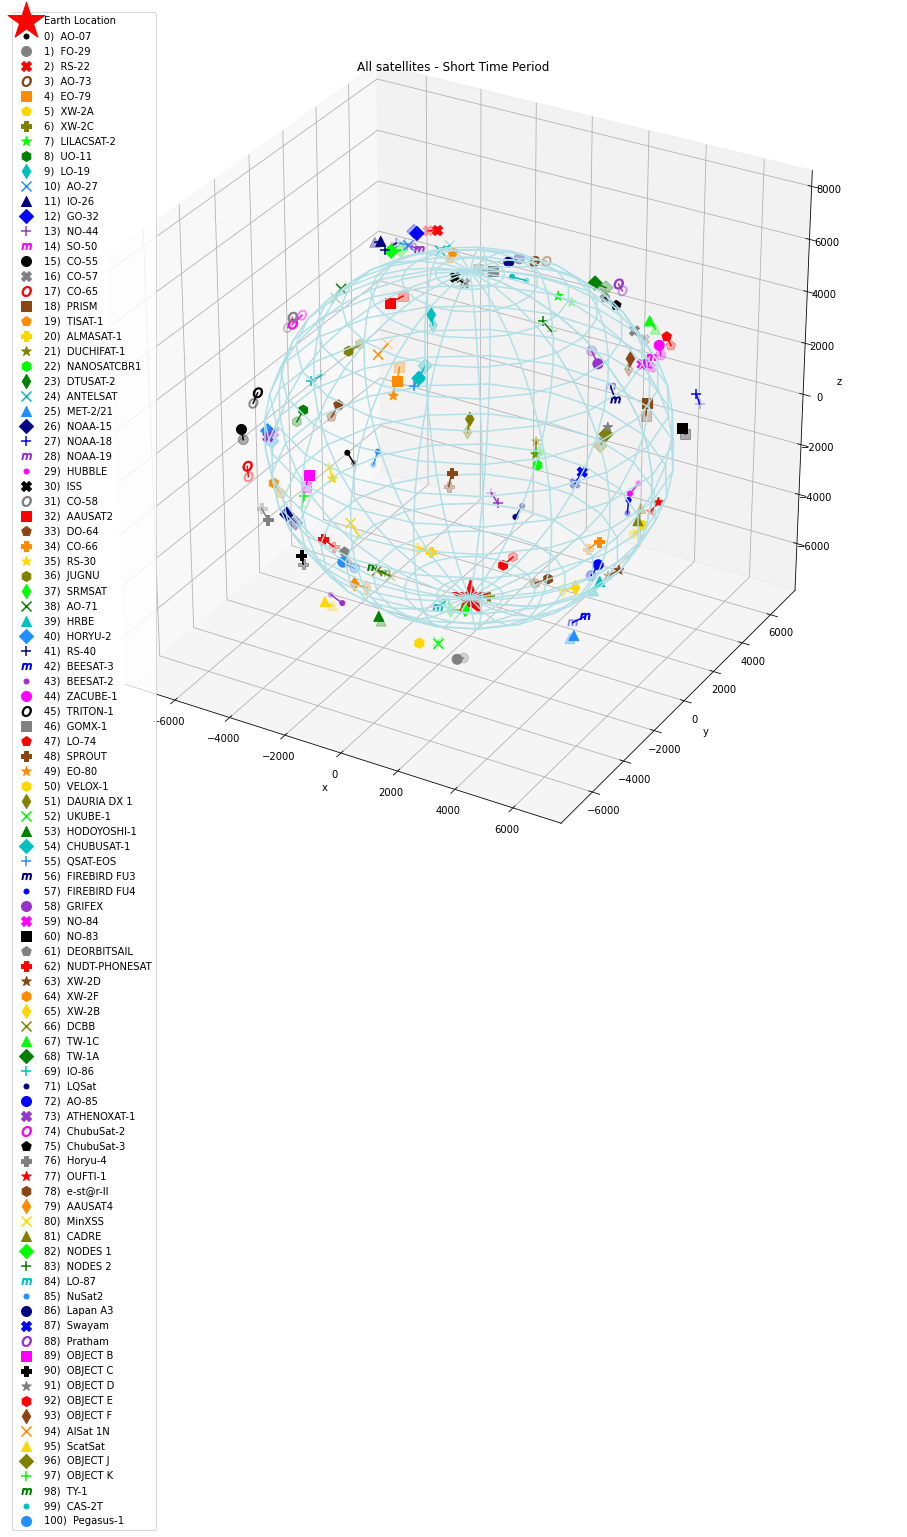

In [5]:
#Plot all satellites over a short period of time (1 minute):


#Chosen Earth Location:
E_loc_X, E_loc_Y, E_loc_Z = 0, 0, -6371


#Creating time points to plot satellites
#jday(year, month, day, hour, minute, second)
#NOTE: I believe the TLE files and the sgp4 package use UTC

#Example:  jday(2017, 1, 10, 13, 4, 30) = 2017, January 10th, 13:04 and 30 seconds
jd0, fr0 = jday(2017, 1, 10, 12, 0, 0)
jd1, fr1 = jday(2017, 1, 10, 12, 1, 0)
jd = np.array((jd0, jd1))
fr = np.array((fr0, fr1))


#Create satellite objects from TLE data
n_sats = int(num_sats_tot)
name_list = []
satellite_list = []
for i in range(n_sats):
    name_list.append(split_lines[i][0][:-1])
    s_i = split_lines[i][1][:-1]
    t_i = split_lines[i][2][:-1]
    satellite_list.append(Satrec.twoline2rv(s_i, t_i))


#From satellite objects at these times, get "e, r, & v"
# e = error code -- non-zero idicates error
# r = position -- cartesian, km from center of earth
#     "in idiosyncratic True Equator Mean Equinox coordinate frame used by SGP4"
# v = velocity

a = SatrecArray(satellite_list)
e, r, v = a.sgp4(jd, fr)


#---------------------------------------------------
#PLOTTING:


fig1 = plt.figure(figsize=(16,16))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_wireframe(xE, yE, zE, color='powderblue')

#Plot chosen Earth location
ax1.scatter(E_loc_X, E_loc_Y, E_loc_Z, marker="*", s=1500, c='red', label='Earth Location')

#Print index and name of any satellites with an error code
#Plot all other satellites
for i in range(len(r)):
    if all(e[i] == [0]*len(jd)):
        xi = r[i][:,0]
        yi = r[i][:,1]
        zi = r[i][:,2]
        ax1.scatter(xi, yi, zi, marker=mkr_2[i], s=100, c=clr_2[i], label=str(i)+")  "+str(name_list[i]))
        ax1.plot(xi, yi, zi, c=clr_2[i])
    else:
        print("ERROR - can't compute: " + str(i) + ") " + str(name_list[i]))

ax1.set_title("All satellites - Short Time Period")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.legend(loc='upper left')

#ax1.view_init(elev=0., azim=0) #yz plane
#ax1.view_init(elev=0., azim=90) #xz plane
#ax1.view_init(elev=-100., azim=45) #xy plane - from below
#ax1.view_init(elev=-45, azim=-45) #from below, angled

plt.show()

In [6]:
#List of all satellites locations -- at first time point (jd0, fr0)

print("Chosen Earth Location (X, Y, Z)  =  "+str(E_loc_X)+", "+str(E_loc_Y)+", "+str(E_loc_Z))
tbl0 = Table().with_columns("Name",name_list, "Index", [i for i in range(len(name_list))],
                           "X_coord", r[:][:,0][:,0], "Y_coord", r[:][:,0][:,1], "Z_coord", r[:][:,0][:,2])
tbl0.show()

Chosen Earth Location (X, Y, Z)  =  0, 0, -6371


Name,Index,X_coord,Y_coord,Z_coord
AO-07,0,-6132.71,2799.35,-3979.38
FO-29,1,1249.56,-2610.12,-6873.77
RS-22,2,-2509.25,1818.3,6319.89
AO-73,3,1823.78,1478.47,6547.22
EO-79,4,347.107,-4981.59,4866.08
XW-2A,5,4002.56,3416.18,-4378.57
XW-2C,6,-299.49,846.388,-6857.47
LILACSAT-2,7,3339.38,310.368,6017.44
UO-11,8,-2532.73,-5664.01,3248.93
LO-19,9,-4539.33,5497.03,684.561


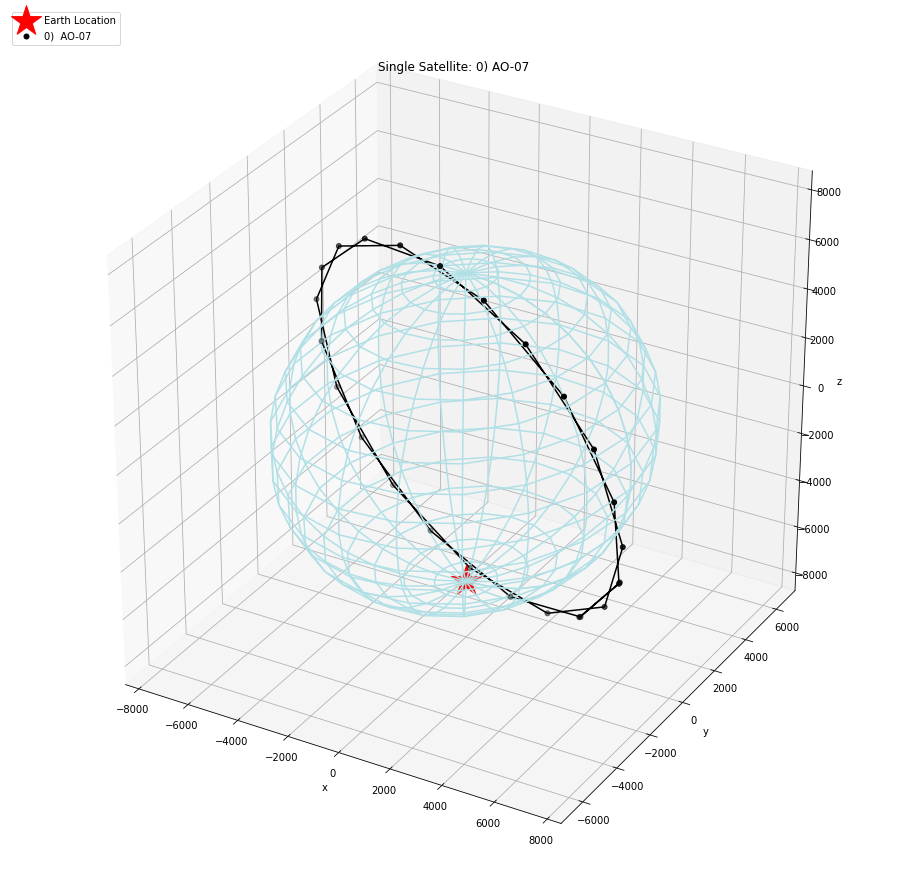

In [7]:
#Plot 1 of those satellite over few hour period


def single_day(num_points, year, month, day, begin_hour, end_hour):
    """
    Inputs:
        num_points: integer, number of data points, use at least a few per orbit
        year, month, day: integers, specifying date
        begin_hour, end_hour: integers, in 24-hour time
    Outputs:
        jd, fr: arrays, times for orbit calculation
    """
    ti = np.linspace(begin_hour, end_hour, num_points)
    jd_list = []
    fr_list = []
    for i in range(num_points):
        jd_i, fr_i = jday(year, month, day, ti[i], 0, 0)
        jd_list.append(jd_i)
        fr_list.append(fr_i)
    return np.array(jd_list), np.array(fr_list)

    
#Creating time points to plot satellites
jd, fr = single_day(num_points=25, year=2017, month=1, day=10,
                    begin_hour = 1, end_hour = 5)


#Create single satellite object
sat_index = 0
single_sat = satellite_list[sat_index]
e, r, v = single_sat.sgp4_array(jd, fr)



#---------------------------------------------------
#PLOTTING:

fig2 = plt.figure(figsize=(16,16))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_wireframe(xE, yE, zE, color='powderblue')

#Plot chosen Earth location
ax2.scatter(E_loc_X, E_loc_Y, E_loc_Z, marker="*", s=1000, c='red', label='Earth Location')

#Plot if no error code
ind = sat_index
if all(e) == 0:
    xi = r[:,0]
    yi = r[:,1]
    zi = r[:,2]
    ax2.scatter(xi, yi, zi, marker=mkr_2[ind], s=100, c=clr_2[ind], label=str(ind)+")  "+str(name_list[ind]))
    ax2.plot(xi, yi, zi, c=clr_2[ind])
else:
    print("ERROR - can't compute: " + str(ind) + ") " + str(name_list[ind]))

ax2.set_title("Single Satellite: " + str(ind) + ") " + str(name_list[ind]))
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.legend(loc='upper left')

plt.show()